In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Lets import important Libraries

In [2]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torch
from torch.utils.data import Dataset,DataLoader
import  cv2
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import roc_auc_score
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
torch.manual_seed(42)

PyTorch Version:  1.10.2
Torchvision Version:  0.11.3


# Read the data

In [3]:
Data_dir = "./data/plant-pathology-2020-fgvc7/images/"
dataframe = pd.read_csv("./data/plant-pathology-2020-fgvc7/train.csv")
test_df = pd.read_csv("./data/plant-pathology-2020-fgvc7/test.csv")
submit = pd.read_csv("./data/plant-pathology-2020-fgvc7/sample_submission.csv")

In [4]:
dataframe['image_id']+='.jpg'
test_df['image_id']+='.jpg'
print(test_df)

           image_id
0        Test_0.jpg
1        Test_1.jpg
2        Test_2.jpg
3        Test_3.jpg
4        Test_4.jpg
...             ...
1816  Test_1816.jpg
1817  Test_1817.jpg
1818  Test_1818.jpg
1819  Test_1819.jpg
1820  Test_1820.jpg

[1821 rows x 1 columns]


In [5]:
label = dataframe.loc[:, 'healthy':'scab']
label = label.values
x = np.argmax(label,axis=1)
dataframe['class'] = x

# Split the dataframe into train and vaidation dataframe
### Also don't forget to reset index of train and validation data frame

In [6]:
train_df, valid_df = train_test_split(dataframe,test_size=0.2,shuffle=True,stratify=dataframe['class'])
train_label = train_df.loc[:, 'healthy':'scab']
valid_label = valid_df.loc[:,'healthy':'scab']
train_df.reset_index(drop=True,inplace=True)
train_label.reset_index(drop=True,inplace=True)
valid_df.reset_index(drop=True,inplace=True)
valid_label.reset_index(drop=True,inplace=True)

In [7]:
train_df.head()

,image_id,healthy,multiple_diseases,rust,scab,class
0,Train_1786.jpg,0,0,1,0,2
1,Train_1510.jpg,0,0,1,0,2
2,Train_716.jpg,0,0,0,1,3
3,Train_1085.jpg,1,0,0,0,0
4,Train_833.jpg,1,0,0,0,0


In [8]:
train_df.shape

(1456, 6)

# Lets's built custom dataset for our work

In [9]:
class Plant_dataset(Dataset):
    
    def __init__(self,df,data_dir,transform,train=True,label=None):
        self.len = df.shape[0]
        self.dir = data_dir
        self.transform=transform
        self.df = df
        self.train=train
        self.label=label
        
    def __len__(self):
        return self.len
    
    def __getitem__(self,idx):
        img_pth = os.path.join(self.dir,self.df['image_id'].loc[idx])
        image = mpimg.imread(img_pth)
        image = cv2.resize(image,(224,224))
        if self.transform:
            image = self.transform(image)
        if(self.train==True):
            labels =np.argmax(self.label.loc[idx,:].values)
        else:
            return image
        return image,labels
    

# Then apply the following transformation:
### 1. Transform to PIL Image
### 2. Transform to Tensor
### 3. Normalization 

In [10]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
train_transf = transforms.Compose([transforms.ToPILImage(),
                                   transforms.ToTensor(),normalize])

valid_transf = transforms.Compose([transforms.ToPILImage(),
                                  transforms.ToTensor(),normalize])
test_transf = transforms.Compose([transforms.ToPILImage(),
                                  transforms.ToTensor(),normalize])

In [ ]:
train_transform = Compose([HorizontalFlip(p=0.5),
                              VerticalFlip(p=0.5),
                              ShiftScaleRotate(rotate_limit=25.0, p=0.7),
                              OneOf([IAAEmboss(p=1),
                                     IAASharpen(p=1),
                                     Blur(p=1)], p=0.5),
                              IAAPiecewiseAffine(p=0.5)])
test_transform = Compose([HorizontalFlip(p=0.5),
                               VerticalFlip(p=0.5),
                               ShiftScaleRotate(rotate_limit=25.0, p=0.7)])
default_transform = Compose([Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225), always_apply=True),
                                 ToTensor()]) #normalized for pretrained network

In [11]:
train_dataset = Plant_dataset(train_df,Data_dir,transform=train_transf,train=True,label=train_label)
valid_dataset = Plant_dataset(valid_df,Data_dir,transform=valid_transf,train=True,label=valid_label)
test_dataset = Plant_dataset(test_df,Data_dir,transform=test_transf,train=False)

#### Let's view some of our image dataset with labels

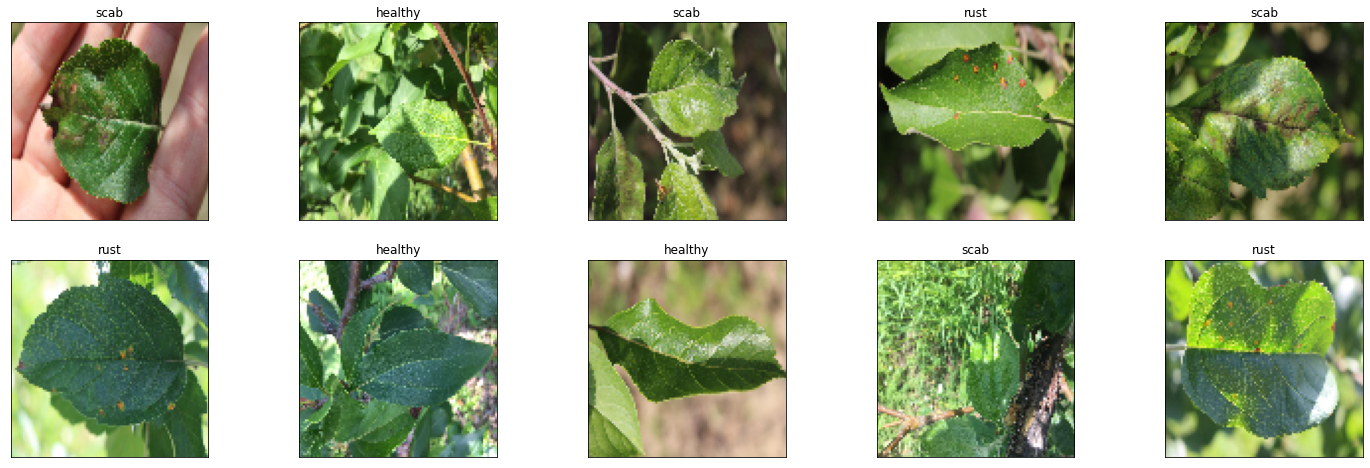

In [12]:
col = train_df.columns
fig = plt.figure(figsize=(25, 8))
for i, idx in enumerate(np.random.choice(train_df.index, 10)):
    ax = fig.add_subplot(2, 10//2, i+1, xticks=[], yticks=[])
    pth = os.path.join(Data_dir,train_df.image_id[idx])
    im = mpimg.imread(pth)
    im = cv2.resize(im, (100, 100)) 
    plt.imshow(im, cmap="hot")
    lab =col[np.argmax(train_df.loc[idx, ['healthy', 'multiple_diseases', 'rust', 'scab']].values)+1]
    ax.set_title(lab)

### Make a dictionary for train_loader and validation_loader

In [13]:
batch_size=32
train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
val_loader = DataLoader(dataset=valid_dataset,batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset,batch_size=batch_size)
dataloaders_dict ={'train':train_loader,'val':val_loader}

#### I am using densenet architecture.
#### You can select any of these given model: [resnet, alexnet, vgg, squeezenet, densenet, inception], you just have to replace model_name with your desired model in the given list.

In [14]:
model_name = "densenet"
num_classes = 4
num_epochs = 10
feature_extract = True
learning_rate = 0.0008

## Note: For fine tunning you just have to make the feature_extract False in above cell. And for feature extraction make the feature_extract True in above cell.
#### Note: During fine tunning try to keep learning rate very small because the model is already trained.

### Lets define training function. For more information you can see pytorch documentation

In [15]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in tqdm(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

### If you are using fine tunning then there is no need to run the below cell as the default value of requires_grad of model.parameters() is true

In [16]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [17]:
def set_parameter_requires_grad2(model):
    for param in model.parameters():
        param.requires_grad = False

In [18]:
def set_parameter_requires_grad3(model):
    print(model.conv0)

### Below cell contain all the model given in the list above. You can try different models and also ensemble all of them for further improvement in accuracy

In [27]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        requires_grad set to false everywhere
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad2(model_ft)
        #set_parameter_requires_grad3(model_ft)
        ct = 0
        for child in model_ft.children():
            ct += 1
            #print(child)
            if ct < 7:
                for param in child.parameters():
                    param.requires_grad = False
                    print(param)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
#print(model_ft)

Parameter containing:
tensor([[[[ 7.8276e-02,  1.4949e-01,  1.6611e-01,  ...,  1.7676e-01,
            1.6588e-01,  1.4101e-01],
          [ 1.7546e-01,  2.4408e-01,  2.5000e-01,  ...,  2.7452e-01,
            2.5245e-01,  2.2199e-01],
          [ 1.2331e-01,  1.6441e-01,  1.4922e-01,  ...,  1.6301e-01,
            1.6191e-01,  1.4061e-01],
          ...,
          [-1.0461e-01, -1.2065e-01, -1.1969e-01,  ..., -1.1355e-01,
           -1.1181e-01, -1.1653e-01],
          [-1.4747e-01, -1.8658e-01, -1.8272e-01,  ..., -2.1694e-01,
           -2.0213e-01, -1.8302e-01],
          [-2.0729e-01, -2.7118e-01, -2.8157e-01,  ..., -2.8711e-01,
           -2.4883e-01, -2.2605e-01]],

         [[ 1.6418e-01,  2.4814e-01,  2.6538e-01,  ...,  2.7358e-01,
            2.5693e-01,  2.2483e-01],
          [ 2.4226e-01,  3.2158e-01,  3.2346e-01,  ...,  3.4569e-01,
            3.1805e-01,  2.8128e-01],
          [ 1.5825e-01,  2.0253e-01,  1.8364e-01,  ...,  1.9484e-01,
            1.8966e-01,  1.6964e-01]

Parameter containing:
tensor([-1.0112e-07,  3.6021e-08, -3.2772e-09,  1.9096e-09,  2.8676e-09,
         6.7636e-02,  1.3022e-09,  8.3347e-09,  3.3176e-08,  2.8157e-08,
         7.6468e-02,  4.4587e-07,  1.2299e-09,  1.9520e-09, -3.2443e-10,
         2.1579e-09,  2.2858e-09,  9.6470e-10,  1.4439e-09,  6.7871e-07,
         2.6134e-09,  1.6789e-06, -8.7998e-08,  9.3620e-10,  7.8089e-10,
         1.1738e-09,  3.7833e-09,  1.1125e-07,  2.8492e-08, -2.0849e-10,
         3.0866e-09,  1.1974e-08,  9.8223e-09, -4.7575e-08, -1.1440e-06,
         1.9388e-08,  1.2535e-08,  5.6911e-08,  3.6359e-07, -9.5674e-11,
         5.5952e-09, -5.4488e-10, -2.6945e-10,  5.0971e-11,  9.8626e-04,
         1.2258e-09,  2.2589e-08, -1.2386e-09,  4.8711e-10,  1.3063e-07,
        -3.3119e-03,  1.8950e-09,  7.9275e-08,  2.1777e-09,  2.0046e-08,
         9.1805e-10,  1.0557e-06,  3.4469e-10,  2.6995e-08, -4.5182e-10,
        -1.3076e-08,  9.0499e-08,  3.0079e-08,  7.2241e-09,  1.5427e-06,
         1.1249e-01,  2.5234e

Parameter containing:
tensor([0.1260, 0.1636, 0.2102, 0.1390, 0.1841, 0.1769, 0.1580, 0.1577, 0.1628,
        0.2269, 0.1771, 0.1828, 0.1641, 0.1884, 0.1726, 0.1712, 0.1681, 0.1833,
        0.1422, 0.1645, 0.1502, 0.1629, 0.1650, 0.1895, 0.1659, 0.1539, 0.1699,
        0.1672, 0.1668, 0.1678, 0.1800, 0.1579, 0.1524, 0.1267, 0.1481, 0.1765,
        0.1666, 0.1407, 0.1618, 0.1460, 0.1944, 0.1450, 0.2078, 0.1563, 0.1823,
        0.1436, 0.1898, 0.1579, 0.1887, 0.1231, 0.2005, 0.1804, 0.1879, 0.1684,
        0.2031, 0.1459, 0.1172, 0.2164, 0.1645, 0.1848, 0.2035, 0.1539, 0.1914,
        0.1479, 0.1138, 0.1448, 0.1598, 0.1893, 0.1507, 0.2130, 0.1558, 0.1733,
        0.1639, 0.1624, 0.1580, 0.1790, 0.1903, 0.1662, 0.1553, 0.1190, 0.1570,
        0.1975, 0.1889, 0.1323, 0.1728, 0.1516, 0.1507, 0.1827, 0.1516, 0.1716,
        0.1639, 0.2029, 0.1678, 0.1980, 0.1045, 0.1624, 0.1521, 0.1820, 0.1891,
        0.1622, 0.2195, 0.1310, 0.1660, 0.1754, 0.1389, 0.1288, 0.0937, 0.1728,
        0.1912, 0.

Parameter containing:
tensor([9.5261e-02, 9.7098e-07, 9.2515e-02, 4.9612e-07, 6.4789e-02, 1.0007e-01,
        5.8901e-02, 9.7631e-02, 1.0883e-01, 7.4099e-02, 8.3083e-02, 1.1652e-01,
        6.8101e-02, 8.5565e-02, 7.1379e-02, 6.4764e-02, 7.4005e-02, 5.1054e-02,
        7.3933e-02, 1.5135e-07, 8.8518e-02, 9.0047e-02, 1.1763e-01, 5.8701e-02,
        1.1373e-01, 4.2043e-02, 8.8242e-09, 6.5451e-02, 6.3521e-02, 1.7801e-02,
        7.4251e-02, 9.2502e-06, 9.8030e-02, 1.8178e-01, 6.6678e-02, 6.9385e-02,
        1.3725e-01, 1.5538e-01, 1.1538e-02, 7.2146e-02, 9.3094e-02, 1.8268e-03,
        7.7724e-06, 7.9413e-02, 5.1149e-02, 8.8102e-02, 1.6102e-08, 4.1249e-02,
        3.5083e-05, 6.9667e-02, 5.1509e-02, 4.7408e-04, 8.8798e-02, 3.9922e-02,
        6.0330e-02, 7.1901e-02, 8.3158e-02, 8.6607e-04, 3.1115e-02, 4.2348e-02,
        2.8060e-02, 4.9060e-02, 1.1720e-01, 8.2247e-02, 7.5608e-02, 6.5664e-02,
        7.2012e-08, 1.1133e-01, 9.5415e-02, 1.0959e-02, 7.4220e-02, 6.4349e-02,
        9.0420e-02

Parameter containing:
tensor([[[[ 2.6107e-03]],

         [[-4.1330e-06]],

         [[ 1.8881e-02]],

         ...,

         [[-2.9637e-02]],

         [[-1.5754e-02]],

         [[ 5.2413e-02]]],


        [[[ 2.8935e-04]],

         [[-1.4973e-05]],

         [[ 3.4295e-03]],

         ...,

         [[ 7.4331e-03]],

         [[-8.4001e-03]],

         [[ 3.4254e-02]]],


        [[[ 1.6743e-03]],

         [[-2.0163e-06]],

         [[ 7.1170e-03]],

         ...,

         [[ 1.0547e-03]],

         [[ 8.8949e-03]],

         [[-5.3439e-02]]],


        ...,


        [[[ 1.0719e-02]],

         [[ 3.6867e-05]],

         [[-2.1874e-02]],

         ...,

         [[-2.0634e-02]],

         [[ 9.5801e-03]],

         [[-4.2968e-02]]],


        [[[-1.2515e-02]],

         [[ 1.4661e-05]],

         [[-1.7212e-02]],

         ...,

         [[-5.4765e-03]],

         [[ 1.6575e-02]],

         [[ 2.8738e-02]]],


        [[[ 8.5431e-03]],

         [[ 3.2628e-05]],

         [[-2.

Parameter containing:
tensor([8.2952e-02, 7.5684e-02, 1.1872e-01, 5.0402e-02, 7.6896e-02, 9.7646e-02,
        7.4229e-02, 9.1484e-02, 8.0104e-02, 7.2004e-02, 6.4939e-02, 7.2580e-03,
        1.6075e-02, 9.0635e-02, 1.6361e-01, 1.1378e-01, 9.2509e-02, 7.8719e-02,
        9.4613e-02, 6.0016e-02, 8.5905e-02, 5.3104e-02, 7.3160e-02, 8.6792e-02,
        4.4720e-02, 8.0792e-02, 9.2966e-02, 3.7240e-06, 1.1210e-01, 6.3012e-02,
        8.4392e-02, 8.2038e-02, 8.6490e-02, 7.0480e-02, 4.5970e-02, 9.1646e-02,
        6.1381e-02, 7.3867e-02, 5.7496e-02, 1.3527e-01, 7.0366e-02, 4.4553e-02,
        4.8887e-02, 6.3073e-02, 7.0616e-02, 3.4750e-02, 7.9702e-02, 8.3719e-02,
        9.3567e-02, 1.4642e-01, 5.3222e-02, 8.7630e-02, 6.2985e-02, 1.6004e-01,
        5.1162e-02, 5.4451e-02, 4.5704e-03, 8.5913e-02, 6.5673e-03, 7.2168e-02,
        1.2935e-01, 5.4675e-02, 5.6362e-02, 6.7343e-02, 5.2302e-02, 6.0396e-02,
        6.7410e-02, 8.3521e-02, 6.9050e-02, 9.2150e-02, 6.3918e-02, 8.9072e-02,
        7.7680e-02

Parameter containing:
tensor([9.2294e-02, 7.3505e-02, 7.2124e-02, 5.1692e-02, 8.1980e-02, 1.0489e-01,
        1.6594e-07, 5.4892e-02, 7.1089e-02, 5.9178e-02, 6.6770e-02, 3.8862e-02,
        3.7985e-02, 7.2690e-02, 1.0206e-01, 8.5909e-02, 8.4669e-02, 1.1465e-01,
        6.2630e-02, 4.0592e-02, 1.0429e-01, 5.1836e-02, 1.1973e-01, 6.7290e-02,
        7.3980e-02, 9.3785e-02, 9.3044e-02, 1.8499e-02, 6.5060e-02, 7.4259e-02,
        8.0174e-02, 7.2897e-02, 7.5240e-02, 7.8933e-02, 3.7097e-02, 3.6700e-02,
        8.6600e-02, 1.0235e-01, 8.1540e-02, 4.4676e-02, 9.8311e-02, 5.2576e-02,
        5.5737e-02, 7.5461e-02, 8.1541e-02, 6.4872e-02, 6.2305e-02, 6.7465e-02,
        1.3153e-01, 7.9072e-02, 1.1947e-01, 7.0384e-02, 7.1666e-02, 7.4940e-02,
        7.0388e-02, 6.3225e-02, 9.2286e-02, 9.7006e-02, 9.1302e-02, 6.1014e-02,
        1.2882e-01, 2.1638e-02, 5.9685e-02, 8.2136e-02, 6.4155e-02, 3.0850e-02,
        6.3969e-05, 9.1099e-02, 7.2852e-02, 1.0983e-01, 6.4230e-02, 3.9347e-02,
        5.1991e-02

Parameter containing:
tensor([[[[-0.0015]],

         [[ 0.0075]],

         [[-0.0026]],

         ...,

         [[ 0.1024]],

         [[-0.0811]],

         [[-0.0013]]],


        [[[ 0.0162]],

         [[-0.0116]],

         [[ 0.0348]],

         ...,

         [[-0.0127]],

         [[ 0.0366]],

         [[ 0.0006]]],


        [[[-0.0197]],

         [[ 0.0022]],

         [[-0.1097]],

         ...,

         [[-0.0082]],

         [[-0.0025]],

         [[-0.0017]]],


        ...,


        [[[-0.0503]],

         [[-0.0154]],

         [[-0.0725]],

         ...,

         [[-0.0225]],

         [[-0.0160]],

         [[-0.0259]]],


        [[[-0.0025]],

         [[-0.0363]],

         [[-0.0098]],

         ...,

         [[-0.0640]],

         [[-0.0516]],

         [[-0.0984]]],


        [[[-0.0332]],

         [[ 0.0092]],

         [[-0.0288]],

         ...,

         [[ 0.0033]],

         [[-0.0457]],

         [[ 0.0029]]]])
Parameter containing:
tensor([0.15

Parameter containing:
tensor([ 6.1099e-02,  7.6645e-02,  8.2639e-02,  4.5353e-02,  4.9964e-02,
         8.3914e-02,  3.9022e-02,  2.1578e-02,  6.9870e-02,  6.2156e-02,
         7.8733e-02,  3.6562e-05,  3.1758e-02,  4.5195e-02,  1.1474e-01,
         4.6072e-02,  1.0702e-02,  9.3190e-02,  6.6761e-02,  4.9140e-03,
         4.2287e-02,  3.1229e-02,  6.9879e-02,  5.4414e-08,  4.6010e-06,
         7.4587e-02,  2.9469e-02,  5.1834e-02,  4.9182e-02,  2.1375e-02,
         8.1634e-04,  3.3745e-02,  4.8380e-02, -4.9031e-04,  6.1980e-02,
         5.9993e-02,  7.8685e-02,  6.8252e-02,  8.6630e-03,  6.9454e-02,
         6.2346e-02,  2.3974e-08,  3.9492e-02,  6.6126e-02,  3.9442e-02,
         4.1842e-02,  2.4309e-02,  9.0825e-08,  2.3130e-02,  6.7382e-02,
         5.7480e-02,  4.9287e-02,  6.2845e-02,  1.3781e-02,  7.7135e-02,
         6.2404e-02,  4.3528e-02,  6.5055e-02,  4.2636e-02,  4.6380e-02,
         8.1617e-02,  4.9004e-02,  7.0500e-02,  4.7411e-02,  5.2699e-02,
         3.3824e-02,  2.3331e

Parameter containing:
tensor([ 5.9573e-02,  5.7182e-02,  6.2469e-02,  2.1293e-02,  9.4787e-02,
         5.3683e-02,  7.9455e-02,  7.0618e-02,  6.3117e-02,  8.2020e-02,
         9.5176e-02,  8.3271e-02,  9.9621e-02,  7.6521e-02,  2.8999e-08,
         6.0965e-02,  1.9219e-02,  8.1401e-02,  6.2371e-02,  1.0943e-01,
         8.2156e-02,  7.8666e-02,  6.0290e-02,  7.7780e-02,  9.1009e-02,
         7.6377e-02,  1.0508e-01,  8.5173e-02,  6.9194e-02,  8.2454e-02,
         9.6601e-02,  6.4844e-02,  6.5261e-02,  5.5466e-02,  7.2863e-02,
         7.3326e-02,  8.6537e-02,  5.6511e-02,  8.0280e-02,  5.6876e-02,
         6.9253e-02,  9.9370e-02,  8.6301e-02,  7.6893e-02,  8.7004e-02,
         9.2865e-02,  6.9959e-02,  9.1001e-02,  3.6894e-02,  8.4608e-02,
         7.5568e-02,  6.5643e-02,  8.2102e-02,  4.1792e-04,  9.9968e-02,
         8.8072e-02,  8.4749e-02,  9.4556e-02,  5.5240e-02,  8.5975e-02,
         4.2144e-02,  5.9670e-02,  8.4098e-02,  9.3525e-02,  8.1540e-02,
         9.7762e-02,  9.6974e

Parameter containing:
tensor([[[[-0.0237]],

         [[ 0.0071]],

         [[ 0.0712]],

         ...,

         [[-0.0006]],

         [[-0.0308]],

         [[ 0.0142]]],


        [[[ 0.0194]],

         [[ 0.0217]],

         [[-0.0086]],

         ...,

         [[-0.1166]],

         [[ 0.0171]],

         [[-0.0132]]],


        [[[ 0.0049]],

         [[ 0.0278]],

         [[-0.0357]],

         ...,

         [[-0.0204]],

         [[-0.0024]],

         [[-0.0155]]],


        ...,


        [[[-0.0028]],

         [[ 0.0096]],

         [[ 0.0033]],

         ...,

         [[-0.0177]],

         [[-0.0008]],

         [[-0.0027]]],


        [[[-0.0079]],

         [[-0.0381]],

         [[ 0.0125]],

         ...,

         [[ 0.0085]],

         [[-0.0038]],

         [[-0.0182]]],


        [[[-0.0055]],

         [[-0.0165]],

         [[-0.0279]],

         ...,

         [[-0.0004]],

         [[-0.0048]],

         [[-0.0073]]]])
Parameter containing:
tensor([0.18

Parameter containing:
tensor([-0.2230, -0.1210, -0.2169, -0.1108, -0.1689, -0.2177, -0.2906, -0.2392,
        -0.2903, -0.1889, -0.2939, -0.2459, -0.2724, -0.2416, -0.1821, -0.2633,
        -0.2371, -0.2182, -0.2612, -0.2069, -0.1934, -0.1916, -0.2217, -0.2020,
        -0.2047, -0.2342, -0.1345, -0.1824, -0.1646, -0.1566, -0.1486, -0.2226,
        -0.2220, -0.2067, -0.1513, -0.3397, -0.2221, -0.1884, -0.1439, -0.1495,
        -0.0906, -0.2305, -0.1062, -0.1993, -0.1535, -0.2065, -0.1243, -0.1418,
        -0.2157, -0.2210, -0.1676, -0.1778, -0.1370, -0.1346, -0.2053, -0.2010,
        -0.1453, -0.1870, -0.1552, -0.1527, -0.1506, -0.1913, -0.2144, -0.1677,
        -0.1624, -0.1382, -0.2092, -0.1890, -0.1140, -0.1373, -0.2117, -0.2400,
        -0.1705, -0.1371, -0.1295, -0.2093, -0.1270, -0.2212, -0.1688, -0.2010,
        -0.2305, -0.3881, -0.2193, -0.1768, -0.1905, -0.1988, -0.1553, -0.1791,
        -0.2155, -0.1235, -0.2509, -0.1538, -0.2465, -0.1638, -0.1911, -0.1466,
        -0.1665, -

Parameter containing:
tensor([ 1.0668e-01,  2.6428e-02,  9.6872e-02,  5.7334e-02,  9.2894e-02,
         7.1717e-02,  7.8450e-02,  8.3663e-02,  9.8616e-02,  8.2798e-02,
         8.4434e-02,  3.6950e-02,  8.0422e-02,  9.1734e-02,  3.1419e-02,
         1.0836e-01,  4.5265e-02,  6.7465e-02,  9.6333e-02,  8.7619e-02,
         9.7056e-02,  7.4179e-02,  9.6461e-02,  9.8259e-02,  8.1177e-02,
         1.0943e-01,  1.0839e-01,  1.3117e-01,  4.3643e-02,  1.0234e-01,
         7.5290e-02,  8.8849e-02,  8.8964e-02,  5.8426e-02,  9.5603e-02,
         1.1949e-01,  8.8754e-02,  1.0489e-01,  1.2172e-01,  7.3841e-02,
         9.8990e-02,  4.9490e-02,  1.1654e-01,  9.3436e-02,  9.0997e-02,
         7.3408e-02,  1.1583e-01,  9.9508e-02,  1.1692e-01,  7.5888e-02,
         1.3422e-01,  9.5291e-02,  7.2459e-02,  6.8420e-03,  8.7570e-02,
         1.1628e-01,  8.6421e-02,  9.2619e-02,  1.1392e-01,  8.3721e-02,
         9.4085e-02,  8.8763e-02,  7.7639e-02,  9.3708e-02,  8.9883e-02,
         1.1092e-01,  1.2501e

Parameter containing:
tensor([1.2281e-01, 1.0622e-01, 1.1414e-01, 1.0958e-01, 9.9195e-02, 1.2404e-01,
        1.1873e-01, 9.9651e-02, 1.4086e-01, 1.1175e-01, 1.0973e-01, 9.7015e-02,
        1.0290e-01, 1.0151e-01, 1.1942e-01, 1.0031e-01, 1.3162e-01, 1.1257e-01,
        1.1859e-01, 1.0181e-01, 1.2404e-01, 1.2577e-01, 1.0419e-01, 1.0355e-01,
        1.2503e-01, 1.2860e-01, 9.6377e-02, 1.3346e-01, 1.1328e-01, 1.1857e-01,
        1.1403e-01, 1.2795e-01, 8.8660e-02, 9.9277e-02, 1.0896e-01, 1.1757e-01,
        1.2691e-01, 1.1295e-01, 9.4596e-02, 1.1058e-01, 1.2548e-01, 1.1790e-01,
        1.2507e-01, 1.2234e-01, 1.1104e-01, 1.2601e-01, 6.4508e-02, 1.1315e-01,
        1.2986e-01, 1.3772e-01, 1.2177e-01, 1.3233e-01, 1.3741e-01, 1.2140e-01,
        1.2759e-01, 1.3153e-01, 1.1037e-01, 9.9953e-02, 1.1546e-01, 9.8989e-02,
        1.3680e-01, 1.1217e-01, 1.0644e-01, 1.2895e-01, 1.0186e-01, 1.0949e-01,
        1.3240e-01, 1.1798e-01, 1.3597e-01, 1.1211e-01, 1.1406e-01, 8.1882e-02,
        9.0892e-02

Parameter containing:
tensor([-0.1722, -0.2195, -0.2306, -0.2576, -0.2024, -0.1099, -0.2118, -0.1794,
        -0.1971, -0.2284, -0.2487, -0.2448, -0.2339, -0.2026, -0.1669, -0.1430,
        -0.2152, -0.2465, -0.1614, -0.3079, -0.2568, -0.1653, -0.2546, -0.1763,
        -0.1508, -0.1030, -0.2238, -0.1733, -0.2187, -0.1454, -0.2678, -0.2251,
        -0.1755, -0.1839, -0.1011, -0.2186, -0.1477, -0.2834, -0.2332, -0.1787,
        -0.1949, -0.1957, -0.1828, -0.2057,  0.0569, -0.1994, -0.0999, -0.1938,
        -0.1386, -0.2714, -0.1592, -0.1624, -0.1573, -0.2966, -0.2731, -0.1757,
        -0.2433, -0.2914, -0.0876, -0.0931, -0.2362, -0.1516, -0.0751, -0.2432,
        -0.1595, -0.2909, -0.2443, -0.1253, -0.1225, -0.0490, -0.0863, -0.1890,
        -0.2132, -0.2256, -0.1247, -0.1309, -0.1852, -0.2027, -0.1719, -0.1448,
        -0.2285, -0.2004, -0.3181, -0.2296, -0.1417, -0.2753, -0.2329, -0.2446,
        -0.2278, -0.1755, -0.1839,  0.0261, -0.1414, -0.1648, -0.0886,  0.0112,
        -0.1815, -

Parameter containing:
tensor([-3.7699e-02, -3.0836e-02, -2.7688e-02, -2.8407e-02, -9.7049e-02,
         1.5569e-02, -2.9705e-02,  1.8476e-02, -5.7834e-02, -3.7289e-03,
        -3.9999e-02, -5.9696e-02, -5.3449e-02, -7.5602e-02,  7.1826e-03,
        -4.8736e-02, -4.0968e-03, -6.3148e-02, -3.8313e-02, -2.6002e-02,
        -2.6251e-02, -2.9194e-02, -3.2769e-02, -4.1244e-02, -9.9362e-03,
         5.2572e-03, -4.0696e-02, -7.0678e-02, -2.4418e-02, -4.7932e-02,
        -2.8264e-02, -2.1241e-02, -2.2626e-02, -5.1143e-02,  3.8020e-02,
        -3.1757e-02, -5.8204e-02, -1.0724e-02, -2.4839e-02, -3.0323e-02,
        -3.2395e-02, -4.8687e-02,  1.0214e-05, -5.0627e-02, -4.2583e-02,
        -3.7569e-02, -2.4591e-02, -4.8250e-02, -7.3605e-02, -2.6085e-02,
        -2.0164e-02, -2.8923e-02, -3.9790e-02,  1.0735e-02, -7.2737e-02,
        -2.3222e-02, -1.9835e-02, -2.8434e-02, -1.7183e-02, -3.6096e-02,
        -5.0830e-02, -3.8284e-02, -2.1471e-02, -7.1411e-03, -3.4477e-02,
         6.6581e-04, -4.9953e

Parameter containing:
tensor([ 1.0572e-01,  1.2180e-01,  1.2129e-01,  1.3157e-01,  1.2413e-01,
         8.7773e-02,  1.2957e-01,  8.6226e-02,  1.1665e-01,  7.8610e-02,
         1.3111e-01,  1.2897e-01,  1.0185e-01,  1.0493e-01,  6.6132e-02,
         8.7120e-02,  1.3156e-01,  1.1132e-01,  9.8555e-02,  9.9291e-02,
         1.0644e-01,  1.2725e-01,  1.0842e-01,  1.2396e-01,  1.1081e-01,
         9.7796e-02,  1.1074e-01,  1.1913e-01,  1.2577e-01,  9.9895e-02,
         1.0602e-01,  9.1041e-02,  1.3144e-01,  9.8416e-02,  1.1369e-01,
         1.1414e-01,  9.5827e-02,  1.3064e-01,  9.7357e-02,  1.0139e-01,
         1.0967e-01,  1.1348e-01,  7.1101e-02,  1.1539e-01,  1.2808e-01,
         1.0498e-01,  7.9826e-02,  1.4204e-01,  9.0087e-02,  1.1033e-01,
         1.1375e-01,  1.1965e-01,  1.2746e-01,  1.3056e-01,  1.3375e-01,
         9.7430e-02,  8.5236e-02,  1.3205e-01,  1.1264e-01,  9.9349e-02,
         1.0488e-01,  9.8130e-02,  1.0434e-01,  9.7584e-02,  1.2434e-01,
         1.3193e-01,  1.0768e

Parameter containing:
tensor([-0.2950, -0.1700, -0.2551, -0.1681, -0.2326, -0.2257, -0.2901, -0.2697,
        -0.2516, -0.2129, -0.1741, -0.1841, -0.2287, -0.1906, -0.2199, -0.2070,
        -0.2408, -0.2552, -0.2335, -0.1553, -0.2693, -0.2312, -0.2484, -0.2394,
        -0.2377, -0.2112, -0.2040, -0.1672, -0.2189, -0.2317, -0.1119, -0.2059,
        -0.2446, -0.2014, -0.2103, -0.1296, -0.2667, -0.2214, -0.1641, -0.3143,
        -0.2078, -0.2436, -0.1828, -0.2163, -0.2105, -0.2867, -0.2726, -0.1976,
        -0.1442, -0.2828, -0.2889, -0.2749, -0.1664, -0.2219, -0.2677, -0.1858,
        -0.2479, -0.2404, -0.1837, -0.1240, -0.2632, -0.3816, -0.2445, -0.2030,
        -0.1937, -0.2339, -0.2098, -0.2445, -0.2713, -0.1692, -0.1665, -0.2670,
        -0.2275, -0.1363, -0.2552, -0.2745, -0.2498, -0.2198, -0.1680, -0.2078,
        -0.2134, -0.2281, -0.1932, -0.2354, -0.2602, -0.2299, -0.1629, -0.2721,
        -0.2135, -0.2941, -0.2265, -0.2604, -0.2370, -0.2426, -0.2376, -0.2118,
        -0.2302, -

Parameter containing:
tensor([[[[-2.2662e-02]],

         [[ 5.0882e-03]],

         [[ 1.0163e-03]],

         ...,

         [[ 4.0083e-07]],

         [[-1.9010e-09]],

         [[-4.8929e-07]]],


        [[[-3.5164e-03]],

         [[-1.0474e-02]],

         [[-1.4306e-02]],

         ...,

         [[-7.2327e-07]],

         [[ 1.0767e-08]],

         [[-2.1234e-06]]],


        [[[-1.8348e-02]],

         [[-2.9445e-02]],

         [[-7.8054e-03]],

         ...,

         [[ 3.5512e-07]],

         [[-1.6737e-08]],

         [[-6.7948e-07]]],


        ...,


        [[[-9.8152e-04]],

         [[-7.9895e-03]],

         [[-1.0246e-02]],

         ...,

         [[-4.5634e-07]],

         [[-1.0764e-08]],

         [[-1.2549e-08]]],


        [[[ 1.9664e-03]],

         [[ 1.3090e-03]],

         [[-6.6399e-03]],

         ...,

         [[-4.5203e-07]],

         [[-5.1274e-10]],

         [[ 1.8984e-07]]],


        [[[ 1.1683e-02]],

         [[-2.1648e-02]],

         [[-2.

In [ ]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

In [18]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [19]:
# Send the model to GPU
model_ft = model_ft.to(device)

In [20]:
##Print all the trainable layer 
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=0.001)

Params to learn:
	 features.conv0.weight
	 features.norm0.weight
	 features.norm0.bias
	 features.denseblock1.denselayer1.norm1.weight
	 features.denseblock1.denselayer1.norm1.bias
	 features.denseblock1.denselayer1.conv1.weight
	 features.denseblock1.denselayer1.norm2.weight
	 features.denseblock1.denselayer1.norm2.bias
	 features.denseblock1.denselayer1.conv2.weight
	 features.denseblock1.denselayer2.norm1.weight
	 features.denseblock1.denselayer2.norm1.bias
	 features.denseblock1.denselayer2.conv1.weight
	 features.denseblock1.denselayer2.norm2.weight
	 features.denseblock1.denselayer2.norm2.bias
	 features.denseblock1.denselayer2.conv2.weight
	 features.denseblock1.denselayer3.norm1.weight
	 features.denseblock1.denselayer3.norm1.bias
	 features.denseblock1.denselayer3.conv1.weight
	 features.denseblock1.denselayer3.norm2.weight
	 features.denseblock1.denselayer3.norm2.bias
	 features.denseblock1.denselayer3.conv2.weight
	 features.denseblock1.denselayer4.norm1.weight
	 features.de

In [21]:
import sys
sys.getrecursionlimit()

3000

In [22]:
#sys.setrecursionlimit(4000)
#sys.getrecursionlimit()
torch.cuda.empty_cache()

In [23]:
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=20, is_inception=(model_name=="inception"))

C:\Users\jonat\AppData\Local\Temp/ipykernel_10996/1428202318.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm(range(num_epochs)):


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0/19
----------
train Loss: 0.4770 Acc: 0.8462
val Loss: 0.3659 Acc: 0.8877

Epoch 1/19
----------
train Loss: 0.3023 Acc: 0.8977
val Loss: 0.3080 Acc: 0.9205

Epoch 2/19
----------
train Loss: 0.1784 Acc: 0.9451
val Loss: 0.3574 Acc: 0.9233

Epoch 3/19
----------
train Loss: 0.1545 Acc: 0.9451
val Loss: 0.3518 Acc: 0.9151

Epoch 4/19
----------
train Loss: 0.1605 Acc: 0.9471
val Loss: 0.2529 Acc: 0.8932

Epoch 5/19
----------
train Loss: 0.0981 Acc: 0.9643
val Loss: 0.4056 Acc: 0.9014

Epoch 6/19
----------
train Loss: 0.1471 Acc: 0.9492
val Loss: 0.3899 Acc: 0.9205

Epoch 7/19
----------
train Loss: 0.0778 Acc: 0.9725
val Loss: 0.3164 Acc: 0.9041

Epoch 8/19
----------
train Loss: 0.0710 Acc: 0.9760
val Loss: 0.3384 Acc: 0.9342

Epoch 9/19
----------
train Loss: 0.1163 Acc: 0.9670
val Loss: 0.3172 Acc: 0.9260

Epoch 10/19
----------
train Loss: 0.0663 Acc: 0.9766
val Loss: 0.2872 Acc: 0.9315

Epoch 11/19
----------
train Loss: 0.0565 Acc: 0.9815
val Loss: 0.3315 Acc: 0.9479

Ep

In [24]:
def prediction(model,dataloader):
    model.eval()
    test_preds = None
    for i,batch in enumerate(dataloader):
        image = batch
        image = image.to(device)
        with torch.no_grad():
            out = model(image)
            if test_preds is None:
                test_preds = out.data.cpu()
            else:
                test_preds = torch.cat((test_preds, out.data.cpu()), dim=0)
    return test_preds

In [25]:
test_pred = prediction(model_ft,test_loader)

In [26]:
submit[['healthy', 'multiple_diseases', 'rust', 'scab']] = torch.softmax(test_pred, dim=1)

In [27]:
submit.to_csv("sample_submission.csv",index=False)

In [28]:
torch.save(model_ft.state_dict(), 'Finetuning_densenet_heavy.pth')

In [32]:
torch.save(model_ft, 'whole_model_heavy2.pth')
#model = torch.load('model.pth')